## SAIL Meteorological Data and Winds from Gothic Town Site

This notebook is used to investigate wind speed and temperature relationships over different time periods from the 2021-2022 winter data acquisition period. From documentation on the surface meteorological station from ARM, heights of measurement are Winds: 10 meters • Temperature and Relative Humidity: 2 meters • Barometric Pressure: 1 meter.

In [1]:
# Import packages
import ftplib
from contextlib import closing
import urllib.request
import io
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import act

Add host name, token and path to data

In [2]:
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
outpath = '/storage/dlhogan/sos/data'

Choose location of data and start/end dates

In [3]:
met ='gucmetM1.b1'
start = '2021-12-10'
end = '2022-04-15' 

Download data to location if not already done

In [4]:
# Download SAIL met data
if not os.path.exists(outpath+'/met'):
    print('Downloading Data...')
    act.discovery.download_data(username, token, met,
                                start, end, output=outpath+'/met')
else: 
    met_ds = act.io.armfiles.read_netcdf(os.path.join(outpath+'/ncdfs','met_ds.nc'))
    print(f'Data already downloaded. Located here: {outpath}/met')


Data already downloaded. Located here: /storage/dlhogan/sos/data/met


Investigate dataset for investigation in remainder of notebook:

In [5]:
met_ds

<xarray.Dataset>
Dimensions:                       (time: 232836, bound: 2)
Coordinates:
  * time                          (time) datetime64[ns] 2021-11-15 ... 2022-0...
Dimensions without coordinates: bound
Data variables: (12/51)
    base_time                     (time) datetime64[ns] 2021-11-15 ... 2022-0...
    time_offset                   (time) datetime64[ns] 2021-11-15 ... 2022-0...
    time_bounds                   (time, bound) object dask.array<chunksize=(232836, 2), meta=np.ndarray>
    atmos_pressure                (time) float32 dask.array<chunksize=(232836,), meta=np.ndarray>
    qc_atmos_pressure             (time) int32 dask.array<chunksize=(232836,), meta=np.ndarray>
    temp_mean                     (time) float32 dask.array<chunksize=(232836,), meta=np.ndarray>
    ...                            ...
    qc_logger_volt                (time) int32 dask.array<chunksize=(232836,), meta=np.ndarray>
    logger_temp                   (time) float32 dask.array<chunksize=(232836,), meta=np.ndarray>
    qc_logger_temp                (time) int32 dask.array<chunksize=(232836,), meta=np.ndarray>
    lat                           (time) float32 dask.array<chunksize=(232836,), meta=np.ndarray>
    lon                           (time) float32 dask.array<chunksize=(232836,), meta=np.ndarray>
    alt                           (time) float32 dask.array<chunksize=(232836,), meta=np.ndarray>
Attributes: (12/25)
    command_line:                met_ingest -s guc -f M1
    Conventions:                 ARM-1.3
    process_version:             ingest-met-4.47-0.el7
    dod_version:                 met-b1-11.0
    input_source:                /data/collection/guc/gucmetM1.00/MET_Table1....
    site_id:                     guc
    ...                          ...
    tbrg_precip_corr_info:       0.000000 * tbrg_precip_total^2 + 0.000000 * ...
    history:                     created by user dsmgr on machine flint at 20...
    _file_dates:                 ['20211115']
    _file_times:                 ['000000']
    _datastream:                 gucmetM1.b1
    _arm_standards_flag:         1

Check some parameters, variables and attributes to see what we have

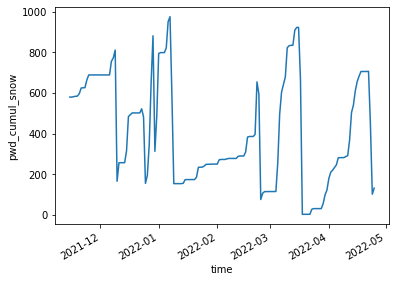

In [20]:
met_ds.where(met_ds.qc_pwd_cumul_snow==0)['pwd_cumul_snow'].resample(time='1D').mean().plot()

Plot diurnal winds and wind rose for the big storm in the end of Decemeber 2021.

<PolarAxesSubplot:title={'center':'SAIL Wind Speed - Dec 23-Jan 1'}>

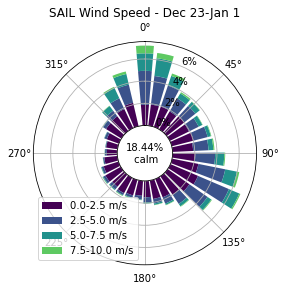

In [8]:
WindDisplay = act.plotting.WindRoseDisplay(met_ds.sel(time=slice('2021-12-23','2022-01-01')), figsize=(4, 5),subplot_shape=(1,))
WindDisplay.plot('wdir_vec_mean', 'wspd_arith_mean',
                 spd_bins=np.linspace(0, 10, 5), num_dirs=30,
                 tick_interval=2, subplot_index=(0,),
                 set_title='SAIL Wind Speed - Dec 23-Jan 1')

In [114]:
def degToCompass(num):
    val=int((num/45)+.5)
    arr=np.arange(0,405,45)
    return arr[(val % 8)]-90

Text(0.5, 0.98, 'Dec 23 to Jan 1 Diurnal Winds')

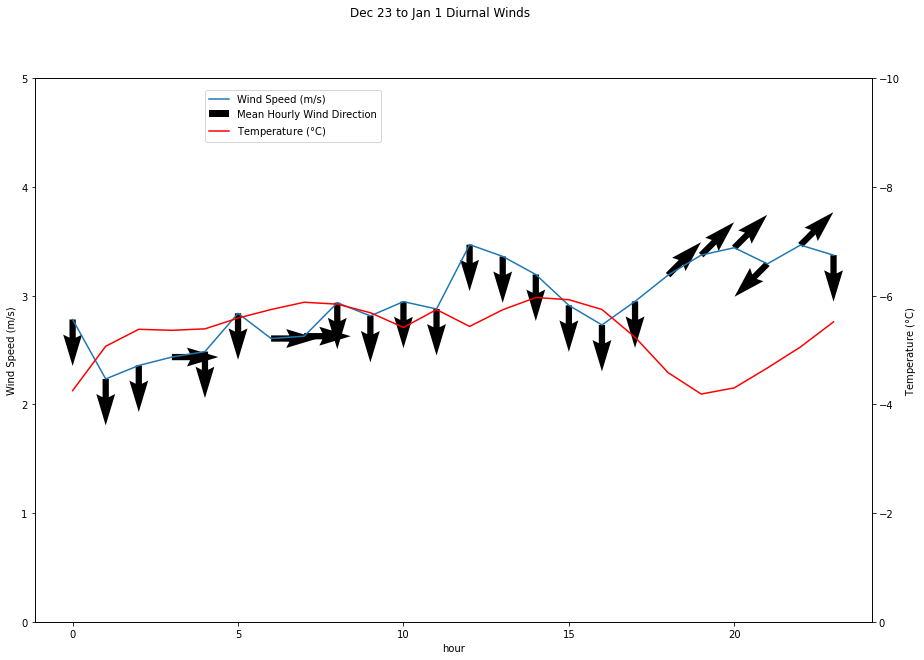

In [117]:
start_date = '2021-12-23'
end_date = '2022-01-01'
met_ds_subset = met_ds.sel(time=slice(start_date,end_date))

cardinal_dirs = [degToCompass(dir) for dir in met_ds_subset.where(met_ds_subset['qc_wdir_vec_mean'] == 0)['wdir_vec_mean'].to_series().values]
cardinal_dirs_df = pd.DataFrame(cardinal_dirs, index=met_ds_subset.time.values, columns=['cardinal_dirs'])

directions = cardinal_dirs_df.groupby(cardinal_dirs_df.index.hour)['cardinal_dirs'].value_counts().groupby(level=0).head(1)
hours = directions.index.get_level_values(0)
direction_strings = directions.index.get_level_values(1)

fig, ax = plt.subplots(figsize=(15,10))

windspd = met_ds_subset.where(met_ds_subset['qc_wspd_arith_mean'] == 0).groupby('time.hour').mean()['wspd_arith_mean'].plot(x='hour',
                                                                                                                            label='Wind Speed (m/s)', 
                                                                                                                            ax=ax)
ax2 = ax.twinx()
temp = met_ds_subset.where(met_ds_subset['qc_temp_mean'] == 0).groupby('time.hour').mean()['temp_mean'].plot(x='hour',
                                                                                                            label='Temperature ($\degree$C)', 
                                                                                                            ax=ax2, 
                                                                                                            color='r')
ax.quiver(met_ds_subset.where(met_ds_subset['qc_wspd_arith_mean'] == 0).groupby('time.hour').mean()['hour'],
            met_ds_subset.where(met_ds_subset['qc_wspd_arith_mean'] == 0).groupby('time.hour').mean()['wspd_arith_mean'],
            np.cos(np.deg2rad(direction_strings)),
            np.sin(np.deg2rad(direction_strings)),
            label='Mean Hourly Wind Direction')
ax.set_ylabel('Wind Speed (m/s)')
ax.set_ylim(0,5)
ax2.set_ylim(0,-10)
ax2.set_ylabel('Temperature ($\degree$C)')

fig.legend(bbox_to_anchor=(0.45, 0.87),
          bbox_transform=fig.transFigure)
fig.suptitle('Dec 23 to Jan 1 Diurnal Winds')

<PolarAxesSubplot:title={'center':'SAIL Wind Speed - Dec-Feb'}>

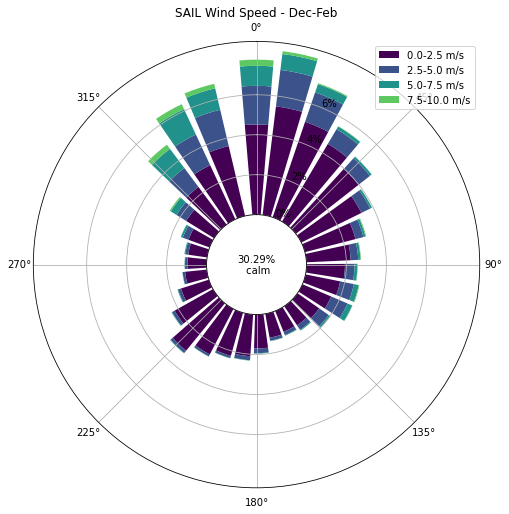

In [7]:
WindDisplay = act.plotting.WindRoseDisplay(met_ds, figsize=(8, 10),subplot_shape=(1,))
WindDisplay.plot('wdir_vec_mean', 'wspd_arith_mean',
                 spd_bins=np.linspace(0, 10, 5), num_dirs=30,
                 tick_interval=2, subplot_index=(0,),
                 set_title='SAIL Wind Speed - Dec-Feb')

<PolarAxesSubplot:title={'center':'SAIL Wind Speed - Jan 4-Jan 8'}>

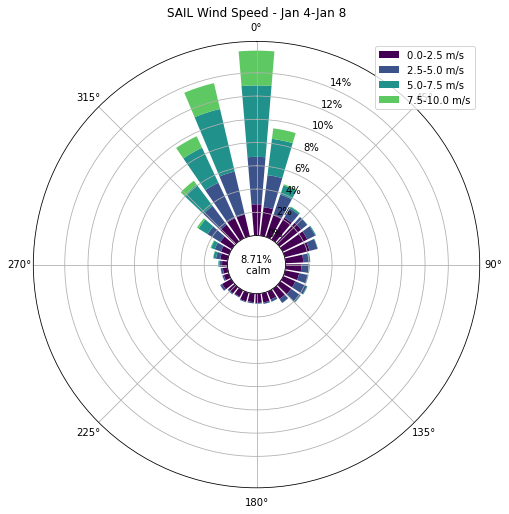

In [8]:
WindDisplay = act.plotting.WindRoseDisplay(met_ds.sel(time=slice('2022-01-04','2022-01-08')), figsize=(8, 10),subplot_shape=(1,))
WindDisplay.plot('wdir_vec_mean', 'wspd_arith_mean',
                 spd_bins=np.linspace(0, 10, 5), num_dirs=30,
                 tick_interval=2, subplot_index=(0,),
                 set_title='SAIL Wind Speed - Jan 4-Jan 8')

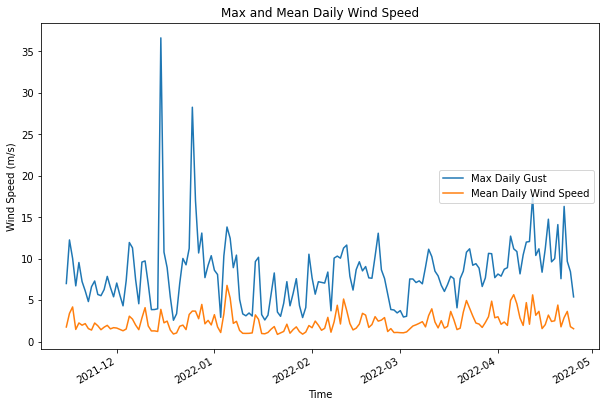

In [27]:
fig,ax =plt.subplots(figsize=(10,6))
met_ds.where((met_ds.qc_wspd_arith_mean==0)).wspd_arith_mean.resample(time='1D').max().plot(ax=ax, label='Max Daily Gust')
met_ds.where((met_ds.qc_wspd_arith_mean==0)).wspd_arith_mean.resample(time='1D').mean().plot(ax=ax, label='Mean Daily Wind Speed')
ax.set_xlabel('Time')
ax.set_ylabel('Wind Speed (m/s)')
ax.set_title('Max and Mean Daily Wind Speed')
ax.legend(loc='center right')

In [20]:
met_df_10min = met_ds.where(met_ds.qc_wspd_arith_mean==0)['wspd_arith_mean'].to_dataframe().resample('10min').max()
vals = [xr.DataArray(data=met_df_10min[c], dims=['time'], coords={'time':met_df_10min.index}, attrs=met_df_10min[c].attrs) for c in met_df_10min.columns]
met_ds_10min = xr.Dataset(dict(zip(met_df_10min.columns,vals)), attrs=met_ds.wspd_arith_mean.attrs)
met_ds_10min

<xarray.Dataset>
Dimensions:          (time: 23328)
Coordinates:
  * time             (time) datetime64[ns] 2021-11-15 ... 2022-04-25T23:50:00
Data variables:
    wspd_arith_mean  (time) float32 3.852 2.065 3.16 4.176 ... 1.427 3.598 2.743
Attributes:
    long_name:            Wind speed arithmetic mean
    units:                m/s
    valid_min:            0.0
    valid_max:            60.0
    valid_delta:          20.0
    ancillary_variables:  qc_wspd_arith_mean

In [35]:
np.nanmedian(met_ds_10min.sel(time=slice('2021-12-22','2021-12-31')).to_array())

3.624

In [36]:
np.nanmedian(met_ds_10min.sel(time=slice('2022-01-01','2022-01-04')).to_array())

2.363

In [37]:
np.nanmedian(met_ds_10min.sel(time=slice('2022-02-10','2022-02-14')).to_array())

2.9664998

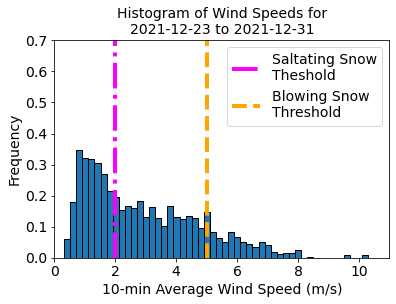

In [40]:
# Historgrams of blowing snow conditions during different periods
fig, ax = plt.subplots()
start = '2021-12-23'
end = '2021-12-31'
met_ds_10min.sel(time=slice(start,end))['wspd_arith_mean'].plot.hist(bins=50, ax=ax, density=True, edgecolor='k')

ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')

ax.set_ylim(0,0.7)
ax.set_xlim(0,11)
ax.set_title(f'Histogram of Wind Speeds for\n{start} to {end}', size=14)
ax.set_ylabel('Frequency', size=14)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('10-min Average Wind Speed (m/s)', size=14)

ax.legend(fontsize=14)

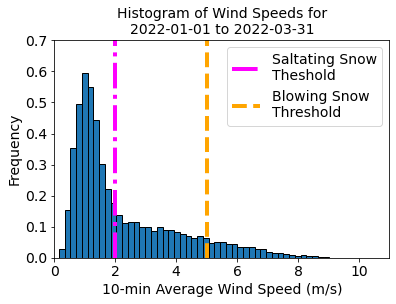

In [41]:
# Historgrams of blowing snow conditions during different periods
fig, ax = plt.subplots()
start = '2022-01-01'
end = '2022-03-31'
met_ds_10min.sel(time=slice(start,end))['wspd_arith_mean'].plot.hist(bins=50, ax=ax, density=True, edgecolor='k')

ax.axvline(2,label='Saltating Snow\nTheshold', color='magenta', lw=4, ls='-.')
ax.axvline(5,label='Blowing Snow\nThreshold', color='orange', lw=4, ls='--')

ax.set_ylim(0,0.7)
ax.set_xlim(0,11)
ax.set_title(f'Histogram of Wind Speeds for\n{start} to {end}', size=14)
ax.set_ylabel('Frequency', size=14)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('10-min Average Wind Speed (m/s)', size=14)

ax.legend(fontsize=14)

In [7]:
total_count = met_ds_10min.count()['wspd_arith_mean']
blowing_snow = met_ds_10min.where(met_ds_10min.wspd_arith_mean>5).count()['wspd_arith_mean']/total_count
saltating_snow = met_ds_10min.where((met_ds_10min.wspd_arith_mean>2) & (met_ds_10min.wspd_arith_mean<5)).count()['wspd_arith_mean']/total_count
calm =met_ds_10min.where(met_ds_10min.wspd_arith_mean<2).count()['wspd_arith_mean']/total_count

In [8]:
%matplotlib inline

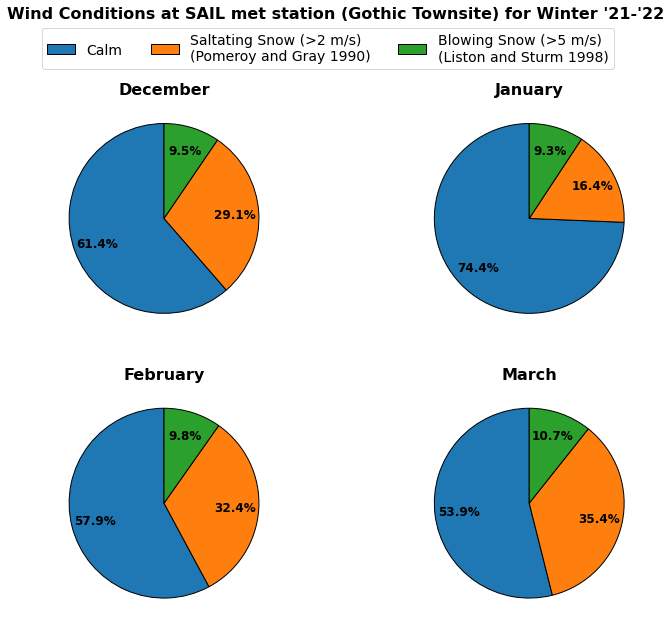

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.set_facecolor('white')
axs=axs.ravel()
titles = ['December', 'January','February','March']
labels = ['Calm','Saltating Snow (>2 m/s)\n(Pomeroy and Gray 1990)', 'Blowing Snow (>5 m/s)\n(Liston and Sturm 1998)']
month_num = [12,1,2,3]
for i, ax in enumerate(axs):
    met_ds_10min_months = met_ds_10min.sel(time=(met_ds_10min['time.month']==month_num[i]))
    total_count = met_ds_10min_months.count()['wspd_arith_mean']
    blowing_snow = met_ds_10min_months.where(met_ds_10min_months.wspd_arith_mean>5).count()['wspd_arith_mean']/total_count
    saltating_snow = met_ds_10min_months.where((met_ds_10min_months.wspd_arith_mean>2) & (met_ds_10min_months.wspd_arith_mean<5)).count()['wspd_arith_mean']/total_count
    calm =met_ds_10min_months.where(met_ds_10min_months.wspd_arith_mean<2).count()['wspd_arith_mean']/total_count

    blowing = 100*blowing_snow
    saltating = 100*saltating_snow
    no_transport = 100 - blowing - saltating
    sizes = [no_transport, saltating,blowing]
    pie_plot = ax.pie(sizes,autopct='%1.1f%%', wedgeprops={'linewidth':1, 'edgecolor':'k'}, 
                      startangle=90, pctdistance=0.75,radius=1, textprops={'color':'black','size': 'large','fontweight':'bold'})
    ax.set_title(f'{titles[i]}', size=16, fontweight='bold')
fig.subplots_adjust(top=0.85)        
fig.suptitle("Wind Conditions at SAIL met station (Gothic Townsite) for Winter '21-'22", size=16, fontweight='bold')
fig.legend(labels, ncol=3, bbox_to_anchor=(0.83,0.96), fontsize=14)

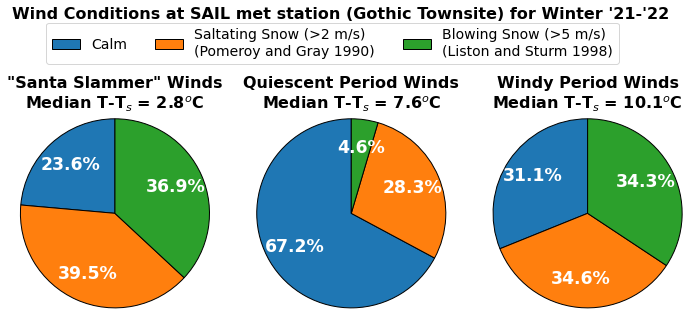

In [53]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
fig.set_facecolor('white')
axs=axs.ravel()
titles = ['"Santa Slammer" Winds\nMedian T-T$_s$ = 2.8$^o$C', 'Quiescent Period Winds\nMedian T-T$_s$ = 7.6$^o$C','Windy Period Winds\nMedian T-T$_s$ = 10.1$^o$C']
labels = ['Calm','Saltating Snow (>2 m/s)\n(Pomeroy and Gray 1990)', 'Blowing Snow (>5 m/s)\n(Liston and Sturm 1998)']
time_slice = [slice('2021-12-22','2021-12-31'),slice('2022-01-20','2022-01-26'),slice('2022-02-10','2022-02-14')]
for i, ax in enumerate(axs):
    met_ds_10min_months = met_ds_10min.sel(time=time_slice[i])
    total_count = met_ds_10min_months.count()['wspd_arith_mean']
    blowing_snow = met_ds_10min_months.where(met_ds_10min_months.wspd_arith_mean>5).count()['wspd_arith_mean']/total_count
    saltating_snow = met_ds_10min_months.where((met_ds_10min_months.wspd_arith_mean>2) & (met_ds_10min_months.wspd_arith_mean<5)).count()['wspd_arith_mean']/total_count
    calm =met_ds_10min_months.where(met_ds_10min_months.wspd_arith_mean<2).count()['wspd_arith_mean']/total_count

    blowing = 100*blowing_snow
    saltating = 100*saltating_snow
    no_transport = 100 - blowing - saltating
    sizes = [no_transport, saltating,blowing]
    pie_plot = ax.pie(sizes,autopct='%1.1f%%', wedgeprops={'linewidth':1, 'edgecolor':'k'}, 
                      startangle=90, pctdistance=0.7,radius=1.2, textprops={'color':'white','size': 'xx-large','fontweight':'bold'})
    ax.set_title(f'{titles[i]}', size=16, fontweight='bold')
# fig.subplots_adjust(top=0.85)        
fig.suptitle("Wind Conditions at SAIL met station (Gothic Townsite) for Winter '21-'22", size=16, fontweight='bold')
fig.legend(labels, ncol=3, bbox_to_anchor=(0.83,0.96), fontsize=14)